In [1]:
from astropy.io import fits, ascii
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
import os, time
from photutils import DAOStarFinder
from astropy.table import QTable
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture, CircularAnnulus
from a345_utilities import print_header         # to use this in your own scripts copy the file a345_utilities.py to your work directory
import astropy.units as unit
from astropy.wcs.utils import pixel_to_skycoord
from photutils import CircularAperture, CircularAnnulus, SkyCircularAperture, aperture_photometry
from matplotlib.colors import LogNorm
from photutils import IRAFStarFinder
from astropy.stats import sigma_clipped_stats
from os import listdir

In [2]:
class Star:
    def __init__(self, ra, dec):
        self.ra = ra
        self.dec = dec
        self.r = Filter()
        self.g = Filter()
        self.i = Filter()

    

class Filter:
        
    def __init__(self): 
        self.flux = []
        self.mag = []
        self.avg_mag = 0
        self.avg_flux = 0
            
    def add(self, flux, mag):
        self.flux.append(flux)
        self.mag.append(mag)
        
        if not np.isnan(mag):
            self.avg_mag = np.mean(self.mag)
            self.avg_flux = np.mean(self.flux)

In [ ]:
"""
#folderpath = f'/data/observatory/student_data/natalia_bajnokova/{target}/Calibrated_{size}/{fltr}/'
folderpathR = f'/data/observatory/student_data/natalia_bajnokova/M67/Calibrated_1800x1200/R/'
folderpathG = f'/data/observatory/student_data/natalia_bajnokova/M67/Calibrated_1800x1200/G/'
folderpathI = f'/data/observatory/student_data/natalia_bajnokova/M67/Calibrated_1800x1200/I/'
dat_filename =  f'/data/observatory/student_data/natalia_bajnokova/M67/Calibrated_1800x1200/data_cluster_stars.dat'


filenames = [folderpathR+f for f in listdir(folderpathR) if f.endswith('.fits')]
filenames+=[folderpathG+f for f in listdir(folderpathG) if f.endswith('.fits')]
filenames+=[folderpathI+f for f in listdir(folderpathI) if f.endswith('.fits')]
filenames.sort()
"""
src = "M67"
size = "3000x3000"


# Specify the platesolved image output path
Input_directory = '/data/observatory/student_data/Alasdairs File/Output_Files/Cluster Photometry/M67/'

# Specify the platesolved image output path
#Output_directory = 'examples/a345/lab_projects/shared-data/student_data/Alasdairs File/Output_Files'

# folderpath = os.path.join(Input_directory)
folderpath = Input_directory

filenames = [f for f in listdir(folderpath) if f.endswith('.fits')]

filenames.sort()

stars = {}

table = np.genfromtxt(f'/data/observatory/student_data/natalia_bajnokova/M67/Calibrated_3000x3000/data_cluster_stars.dat', names=True,dtype=None)
ra = table['RA']
dec = table['DEC']

for file in (filenames):
    #import fit
    print (file)
    with fits.open(folderpath+file) as hdu:
        header = hdu[0].header
        data = hdu[0].data
    
    filtr = header["FILTER"][0]
    wcs = WCS(header)
    bkg_sigma = mad_std(data)        # get a measure of the image noise level
    SeeingStars = IRAFStarFinder(fwhm=8, threshold=50*bkg_sigma, brightest=250)     # set the detection threshold for a source based on the image noise
    SeeingStars = SeeingStars(data)
    fwhm = np.mean(SeeingStars['fwhm']) # calculates the average size of the stars in the image

    # convert ra and dec positions to pixel positions in the image
    xc,yc = wcs.wcs_world2pix(ra, dec, 1)
    PixPos = np.transpose((xc,yc))
    
    # sets the aperature and radii to use
    pix_radius = 4*fwhm/2 # 4 times the average star raduis to collect all the possible photons
    In_ann = pix_radius*1.2; Out_ann = (In_ann+1)*1.3 # annulus measurements from 1.2*aperture to 1.3*aperture
    
    # aperture photometry data
    aperture = CircularAperture(PixPos, r=pix_radius) # creating the cicular apertures cnetred on the star positions
    annulus_aperture = CircularAnnulus(PixPos, r_in=In_ann, r_out=Out_ann) # creating the annulus apertures cnetred on the star positions
    apers = [aperture, annulus_aperture]
    # Send the created apertures and the calibrated data to do the photometry
    print('stars and apertures created with wcs_world2pix, starting aperture photometry')
    phot_table = aperture_photometry(data, apers)
    
    phot_table['RA'] = ra; phot_table['DEC'] = dec                  # add to the table columns for Ra and Dec coordinates of the stars
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area # average value of the annulus around each star
    phot_table['background_mean'] = bkg_mean                        # adding the background level to the output table
    bkg_sum = bkg_mean * aperture.area                              # background for each star
    final_sum = phot_table['aperture_sum_0'] - bkg_sum              # The actual photometry results
    filter_counts_name = 'counts_'+header['FILTER']
    filter_flux_name = 'flux_'+header['FILTER']
    phot_table[filter_counts_name] = final_sum                      #  adding results to the output table
    filter_flux = final_sum/header['EXPTIME']
    phot_table[filter_flux_name] = filter_flux
    phot_table[f"mag {header['FILTER']}"] =-2.5*np.log10(filter_flux)

    """
    #Plotting

    fig = plt.figure(figsize=(20,20))
    plt.imshow(data, cmap="gray", norm=LogNorm(vmin = bkg_mean, vmax=bkg_mean+200) )
    star_aperature.plot(color="red")
    annulus_aperature.plot(color="green")
    plt.show()
    """


    
    ra, dec = wcs.wcs_pix2world(phot_table["xcenter"],phot_table["ycenter"], 1)

    flux = phot_table[filter_flux_name]
    count = phot_table[filter_counts_name]
    mag = phot_table[f"mag {header['FILTER']}"]
    tbl = QTable([ra , dec, flux, count, mag], names=('RA','DEC', "flux", "count", "mag"), masked=True)
    tbl.sort("flux")
    tbl.reverse()
    
    ascii.write(tbl, f'/data/observatory/student_data/natalia_bajnokova/{src}/Calibrated_{size}_small/{filtr}/data_{file}.dat')
    for row in tbl:
        
        if row["mag"] == "nan":
            pass
        else:
            r = round(row["RA"], 4)
            d = round(row["DEC"], 4)
            k = f"{r}, {d}"
            if k in stars:
                if filtr == "G":
                    obj = stars[k]
                    obj.g.add(row["flux"], row["mag"])
                elif filtr == "I":
                    obj = stars[k]
                    obj.i.add(row["flux"], row["mag"])
                else:
                    obj = stars[k]
                    obj.r.add(row["flux"], row["mag"])
            else:
                if filtr == "G":
                    stars[k] = Star(r, d)
                    stars[k].g.add(row["flux"], row["mag"])
                elif filtr == "I":
                    stars[k] = Star(r, d)
                    stars[k].i.add(row["flux"], row["mag"])
                else:
                    stars[k] = Star(r, d)
                    stars[k].r.add(row["flux"], row["mag"])
return stars

In [ ]:
"""
stars = {}

for file in (filenames):
    #import fit
    print (file)
    with fits.open(file) as hdu:
        header = hdu[0].header
        data = hdu[0].data
    
    filtr = header["FILTER"][0]
    wcs = WCS(header)
    data_std = mad_std(data)
    d_max = np.max(data)
    d_med = np.median(data) 
    d_lower =d_med                   #good if we want to ignore background
    d_upper_corrected=(d_max*d_med)**0.5

    bkg_med = np.median(data) 
    bkg_mean = np.mean(data)
    bkg_std = np.std(data)
    data_std = mad_std(data)

    #import of platesolved stars  
    table = np.genfromtxt(dat_filename,names=True,dtype=None)

    #convert skycoord to pix
    x, y = wcs.wcs_world2pix(table["RA"], table["DEC"], 1)
    pix_coord = np.transpose((x, y))
    #define aperatures
    star_aperature = CircularAperture(pix_coord, r = 6)
    annulus_aperature = CircularAnnulus(pix_coord, r_in = 9, r_out = 11)
    aperature_join = [star_aperature, annulus_aperature]

    
    #Plotting

    fig = plt.figure(figsize=(20,20))
    plt.imshow(data, cmap="gray", norm=LogNorm(vmin = bkg_mean, vmax=bkg_mean+200) )
    star_aperature.plot(color="red")
    annulus_aperature.plot(color="green")
    plt.show()
    

    #Performing photometr
    phot_table = aperture_photometry(data, aperature_join)


    #annulus mean
    bkg_mean_annulus = phot_table['aperture_sum_1']/annulus_aperature.area

    #annulus median
    annulus_masks = annulus_aperature.to_mask(method='center')
    bkg_median = []
    for mask in annulus_masks:
        annulus_data = mask.multiply(data)
        annulus_data_1d = annulus_data[mask.data > 0]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)

    bkg_median = np.array(bkg_median)
    phot_table['annulus_median'] = bkg_median

    #star aperture background
    phot_table['aper_bkg'] = bkg_median * star_aperature.area

    #corrected star aperture
    correct_aperature = phot_table['aperture_sum_0'] - phot_table['aper_bkg']

    phot_table['aper_sum_bkgsub'] = correct_aperature

    #magnitude of star
    phot_table[f"mag {fltr}"] =-2.5*np.log10(correct_aperature)

    
    ra, dec = wcs.wcs_pix2world(phot_table["xcenter"],phot_table["ycenter"], 1)

    flux = phot_table['aper_sum_bkgsub']
    mag = phot_table[f"mag {fltr}"]
    tbl = QTable([ra , dec, flux, mag], names=('RA','DEC', "flux", "mag"), masked=True)
    tbl.sort("flux")
    tbl.reverse()
    
   
    for row in tbl:
        
        if row["mag"] == "nan":
            pass
        else:
            r = round(row["RA"], 4)
            d = round(row["DEC"], 4)
            k = f"{r}, {d}"
            if k in stars:
                if filtr == "G":
                    obj = stars[k]
                    obj.g.add(row["flux"], row["mag"])
                elif filtr == "I":
                    obj = stars[k]
                    obj.i.add(row["flux"], row["mag"])
                else:
                    obj = stars[k]
                    obj.r.add(row["flux"], row["mag"])
            else:
                if filtr == "G":
                    stars[k] = Star(r, d)
                    stars[k].g.add(row["flux"], row["mag"])
                elif filtr == "I":
                    stars[k] = Star(r, d)
                    stars[k].i.add(row["flux"], row["mag"])
                else:
                    stars[k] = Star(r, d)
                    stars[k].r.add(row["flux"], row["mag"])
"""

In [27]:
print ([s.g.mag for s in stars.values()][0])

[-10.807928293308809, -10.756031040804295, -10.443676893632666, -10.757402777859076, -10.569226804749372, -10.572524190577916, -10.798796959131627, -10.343972460558424, -10.111216903270723, -10.024633681733548, -9.305020780237294, -9.223372706807792, -9.771300656987558, -9.460466218235181, -9.233763057570917, -9.399642246362605, -9.335399463755754, -9.264334351460555, -9.107022665145468, -9.405223199652056, -10.482489124358686, -10.385533937020096, -10.293655167352473, -10.433337730456769, -10.483752177097257, -10.537087806372883, -10.580993548036165, -10.575088973706467, -10.561684472925608, -10.236538304079373, -10.249793958903977, -10.356570297346824, -10.423536282256746, -10.408699226557863, -10.27475226472461, -10.44383708654377, -10.341771947956813, -10.452943151272425]


In [49]:
R = []
G = []
I = []
for obj in stars.values(): 

    I.append(obj.i.avg_mag)
    G.append(obj.g.avg_mag)
    R.append(obj.r.avg_mag)


print (len(np.subtract(I,G)))
y = np.subtract(G,R)
k = 0
for i in y:
    if i == 0:
        print ("Problem")
        print (k)
    k +=1


396
Problem
393
Problem
395


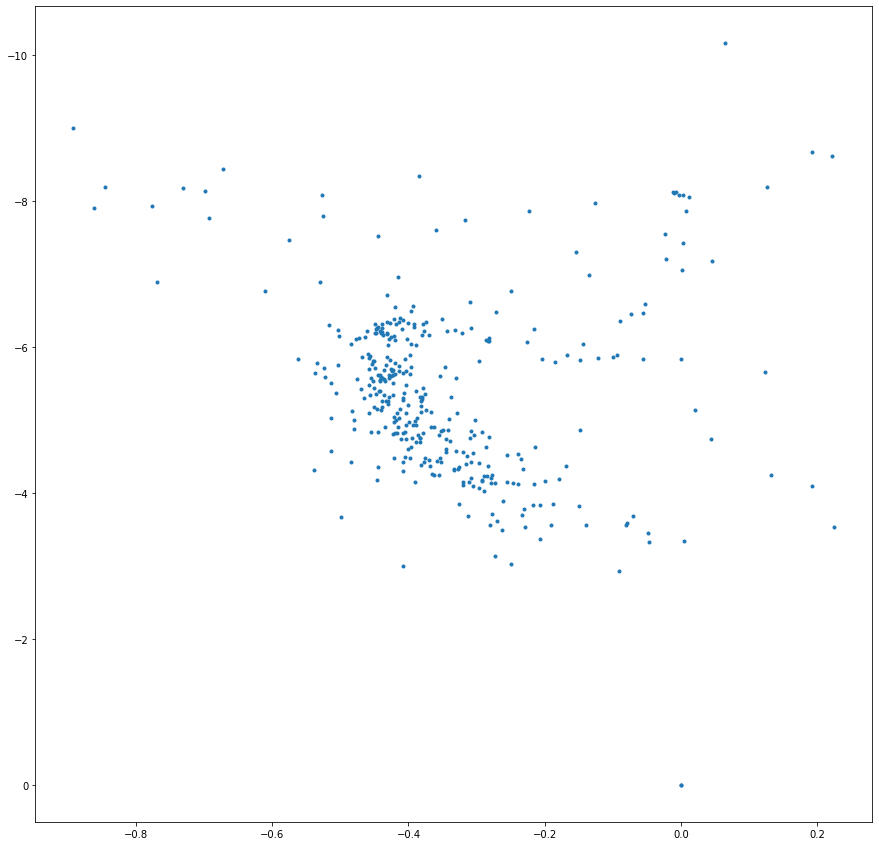

In [52]:
plt.figure(figsize=(15,15))
plt.plot(y, G, ".")
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.show()

In [54]:
i = []
g= []
r = []
for obj in stars.values(): 

    i.append(obj.i.mag)
    g.append(obj.g.mag)
    r.append(obj.r.mag)

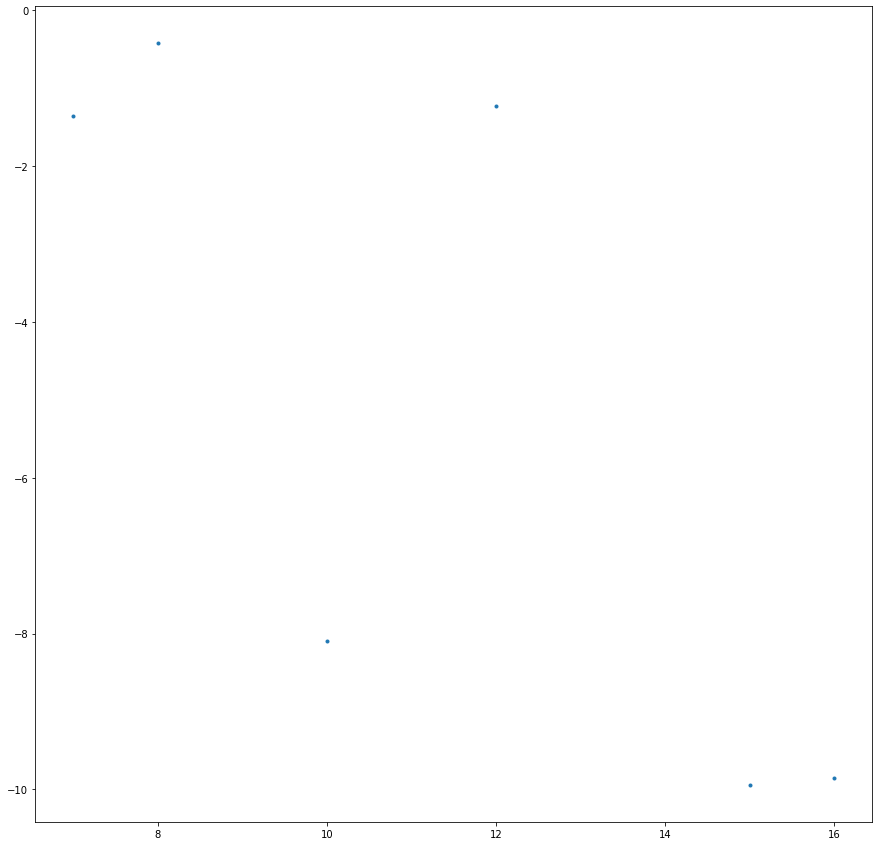

[nan, nan, nan, nan, nan, nan, nan, -1.3553752220343966, -0.4255052994072184, nan, -8.092196642724806, nan, -1.2332550072911852, nan, nan, -9.941223780264005, -9.856494148252734, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [58]:
plt.figure(figsize=(15,15))
plt.plot(range(len(r[3])),r[3], ".")
plt.show()
print (r[3])